In [57]:
import numpy as np
import pylab as plt
import astropy.constants as const

#load constants

pi     = np.pi
AU     = const.au.cgs.value
pc     = const.pc.cgs.value
Mearth = const.M_earth.cgs.value
Mjup   = 315.*Mearth
Rearth = const.R_earth.cgs.value
Msun   = const.M_sun.cgs.value
G      = const.G.cgs.value
amu    = const.u.cgs.value
kb     = const.k_B.cgs.value
Rgas   = const.R.cgs.value
c      = const.c.cgs.value
yr     = 3.1558149504e7
Myr    = 1e6*yr
sb     = const.sigma_sb.cgs.value
sT     = 6.65e-25 #cm2 - Thomson cross section

mmol=2.4
gamma=1.4
Rgasmu=Rgas/mmol
cp=gamma*Rgasmu/(gamma-1)
stbz = const.sigma_sb.cgs.value
temperature_background=3
alpha = 1e-4 

# # parameters for AGN
#Implement the magnetic field parameters like beta and modify the density and the sound speed accordingly ...
betam    = 0.01
M8      = 1.0
# M       = 1e8* Msun * M8 #default black hole mass
rs      = pc #2*G*M/c**2 #change it to whatever normalization needed (e.g. pc, AU or rs)
#the rs does add confusion due to mass inversion 
n       = 100
r       = np.logspace(-1,2,n) * pc
b       = 0
kappa_es = 0.4

vfrag   = 100
SI_St_threshold = 1e-2  #Stokes number threshold for Streaming Instability

Zfil    = 0.1
Z       = 0.01

coagulation_efficiency = 0.5
rho_bullet = 3.

R0   = 1e-4 #cm
temperature_background=3
Sc = 10 # Schmidt number; delta=alpha/Sc=1e-5, typical streaming
Mjup = 315. * Mearth


In [58]:
def get_phi(Mbh,temp, dens, omega):
    """
    Computes the LHS of the thermal balance equation and optionally its derivatives.
    
    Returns:
    - phi
    - dphi (if compute_derivatives)
    - d2phi (if compute_derivatives)
    """
    cs       = np.sqrt(temp * cp * (gamma - 1))
    dlnHdlnR = 9./7 
    
    rho      = dens
    H        = cs/omega * np.sqrt(1 + 1./betam)
    sigma    = 2.*H*rho
    rstar    = 6.*G*Mbh/c**2

    nu       = alpha*cs*H
    mdot     = np.mean(3*pi*nu*sigma)
    tstar    = (3./(8*pi) * mdot * (G*Mbh/rstar**3.)/ sb)**0.25
    kappa    = calc_opacity(Mbh, temp, rho)

    tau      = 0.5 * kappa * sigma
    taueff   = 0.375 * tau + 0.43301270 + 0.25 / tau

    edot     = 0.75 / np.pi * mdot * omega**2

    rr       = (G* Mbh / omega**2)**(1./3)
    grazing_irradiation     = 2.0 / (3 * np.pi) * (rstar/rr)**3
    flaring_term            = 0.5 * (rstar/rr)**2 * (H/rr) * (dlnHdlnR - 1)
    term                    = max(grazing_irradiation + flaring_term, 0.0)
    temperature_irradiation = tstar * term**0.25

    phi                     = 2 * stbz * (temp**4 - temperature_background**4 - temperature_irradiation**4) - taueff * edot

    #print(rs/pc,temperature_irradiation)
    
    #phi = 2 * stbz * (temp**4 - temperature_background**4) - taueff * edot
    #phi = 2 * stbz * temp**4 - taueff * edot    
    
    return phi
    
def bisection(Mbh, left, right, dens, omega):
    """
    Bisection root-finding method for the temperature equation.
    
    Returns:
    - temperature
    """
    maxit  = 1000
    icount = 0
    while abs(right - left) > 2 * temperature_precision:
        midpoint = 0.5 * (right + left)
        phileft  = get_phi(Mbh, left, dens, omega)
        phimid   = get_phi(Mbh, midpoint, dens, omega)
        if phileft * phimid < 0:
            right = midpoint
        else:
            left = midpoint

        icount += 1
        if icount > maxit:
            print("left, right =", left, right)
            raise RuntimeError("bisection: exceeds maximum number of iterations")

    temperature = 0.5 * (right + left)

    return temperature

def calc_opacity(Mbh, tt, rho):
    """
    Computes opacity using piecewise fits from Bell et al. (1997).
    
    Returns:
    - kappa_cte (k)
    - b_exp (b)
    - a_exp (a)
    - kappa (kk)
    """
    if tt < 0:
        raise ValueError("calc_opacity: negative temperature")

    if tt <= T1:
        k, a, b = 2e-4, 0, 2.1
        kk = k * tt**b
    elif T1 < tt <= T2:
        k, a, b = 3.0, 0, -0.01
        kk = k * tt**b
    elif T2 < tt <= T3:
        k, a, b = 0.01, 0, 1.1
        kk = k * tt**b
    elif T3 < tt <= T4:
        k, a, b = 5e4, 0, -1.5
        kk = k * tt**b
    elif T4 < tt <= T5:
        k, a, b = 0.1, 0, 0.7
        kk = k * tt**b
    elif T5 < tt <= T6:
        k, a, b = 2e15, 0, -5.2
        kk = k * tt**b
    elif T6 < tt <= T7:
        k, a, b = 0.02, 0, 0.8
        kk = k * tt**b
    elif T7 < tt <= T8:
        logk, a, b = 81.3010, 1.0, -24.0
        logkk = logk + a * np.log10(rho) + b * np.log10(tt)
        kk = 10**logkk
        k = 1e33
    elif T8 < tt <= T9:
        k, a, b = 1e-8, 2.0 / 3, 3.0
        kk = k * rho**a * tt**b
    else:
        if lroot:
            print(f"calc_opacity: volume density {rho} g/cm^3")
            print(f"calc_opacity: temperature {tt} K. Higher than maximum allowed, {T9}")
        raise ValueError("calc_opacity: temperature exceeds valid range")

    return kk

T1=132.
T2=170.
T3=375.
T4=390.
T5=580.
T6=680.
T7=960.
T8=1570.
T9=3730.
temperature_precision=0.1


In [59]:
# @title SG03 main function
def agndisk(Mbh,alphain,le):
    Mbh   = Mbh*Msun
    M     = Mbh
    kappa = np.zeros(n)
    Temp  = np.zeros(n)
    Qmin  = 1.
    Omega  = np.sqrt(G*Mbh/r**3)
    rho    = Omega**2/(2*np.pi*G*Qmin)
    # rmin   = (2*G*Mbh/c**2)/(4*epsilon)
     
    for i in range(n):
        Temp[i]  = bisection(Mbh, T9, temperature_background,rho[i], Omega[i])
    # print(Temp)
    cs    = np.sqrt(Temp * cp * (gamma - 1))
    H     = cs/Omega*np.sqrt(1+1/betam)
    Sigma = rho*2*H
    
    for i in range(n):
        kappa[i] = calc_opacity(Mbh, Temp[i], rho[i])
    tau  = .5*kappa*Sigma
    #nu   = alpha*cs*H
    #Mdot = np.mean(3*pi*nu*Sigma)
    # Teff_visc     = (3./(8*pi) * Mdot * Omega**2/ stbz)**0.25

    # taueff = 0.375 * tau + 0.43301270 + 0.25 / tau

    #Teff = (3./(8*pi) * Mdot * Omega**2/ sb)**0.25

    output = {'rrs': [r"$r/rs$",r/rs],
                'h': [r"$H/r$",H/r],
                'rho': [r"$\rho \, [\mathrm{g\,cm^{-3}]}$",rho], #g/cm^3
                'tau': [r"$\tau$",tau],
                'T': [r"$T \, [\mathrm{K}]$",Temp],
                #'Teff': [r"$T_{eff} \, [\mathrm{K}]$",Teff],
                'kappa': [r"$\kappa \, [\mathrm{cm^2 g^{-1}}]$",kappa],
                'cs': ["$c_s [\mathrm{cm\,s^{-1}}]$",cs],
                'Sigmag':[r"$\Sigma[\mathrm{g\,cm^{-2}}]$",Sigma],
                # 'Omega':[r"$\varOmega$",Omega],
                'MtotM':[r"$M_\mathrm{disk}/M_\mathrm{BH}$",np.pi*r*r*2.*H*rho/M],
                'MtotU':[r"$M_\mathrm{most unst.}\,[M_\odot]$",(cs**4./(G**2.*2.*H*rho))/Msun],
                'Omega':[r"$\Omega$", Omega],
                'rs':[r"rs",pc],
                
                }
    return output

    #print("i, Radius, Number of iterations:", i, r[i]/rs,icount)
    # return r, rs, kappa, rho, beta, tau, cs, Temp, Q, Teff, Sigma, H

# @title Initial parameters to plot the SG03 model and get Streaming Instability details
font   = 14
cutr   = 0
Mbhi   = []
alphai = []

variablembh   = ['$M_{bh}=10^9\\,M_\\odot$','$M_{bh}=10^8\\,M_\\odot$','$M_{bh}=10^7\\,M_\\odot$']
variablealpha = ['$\\alpha=1e-2$','$\\alpha=1e-3$','$\\alpha=1e-4$']

plotvar       = variablembh
if(plotvar == variablembh):
    alphai = [alpha,alpha,alpha]
    Mbhi   = [1e9, 1e8, 1e7]

if(plotvar == variablealpha):
    alphai = [1e-2,1e-3,1e-4]
    Mbhi   = [1e6, 1e6, 1e6]

print("The parameters for the plots below")
print("==========================================================")
print('The black hole mass is = ', "{:.1e}".format(Mbhi[0]), "{:.1e}".format(Mbhi[1]), "{:.1e}".format(Mbhi[2]) )
print('The viscosity parameter alpha = ', "{:.1e}".format(alphai[0]), "{:.1e}".format(alphai[1]), "{:.1e}".format(alphai[2]))
print("==========================================================")
param_dic1 = agndisk(Mbhi[0],alphai[0],0.5)
param_dic2 = agndisk(Mbhi[1],alphai[1],0.5)
param_dic3 = agndisk(Mbhi[2],alphai[2],0.5)


The parameters for the plots below
The black hole mass is =  1.0e+09 1.0e+08 1.0e+07
The viscosity parameter alpha =  1.0e-04 1.0e-04 1.0e-04


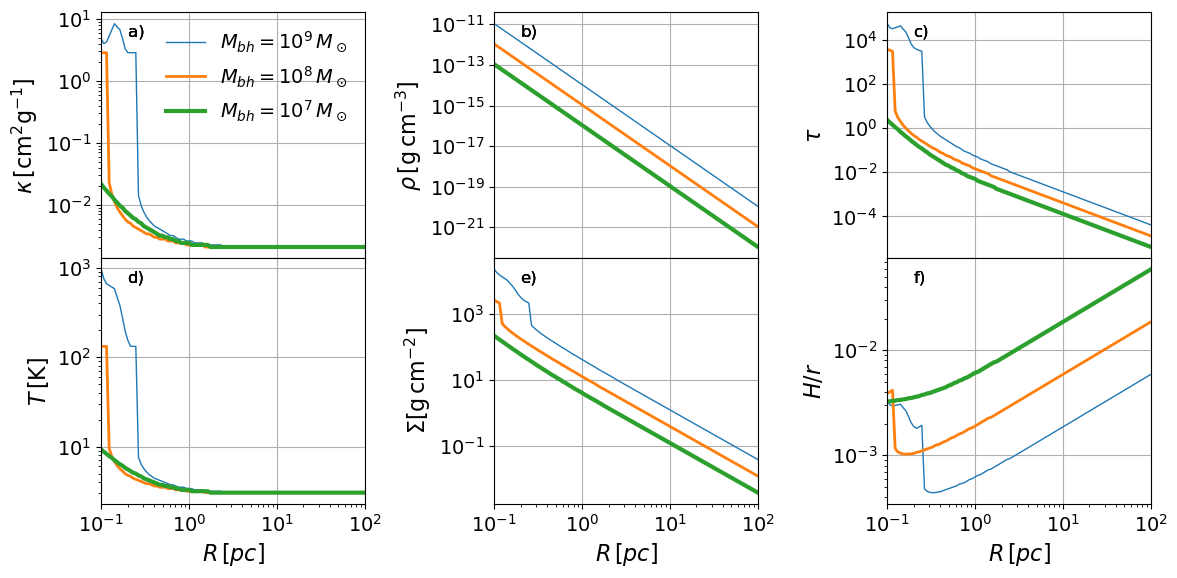

In [60]:
f, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, gridspec_kw=dict(hspace=0), tight_layout=True)
def plotsg03(param_dic,lw,variable):
    ax[0][0].plot(param_dic['rrs'][1][cutr:], param_dic['kappa'][1][cutr:],lw=lw,label=variable)
    ax[0][1].plot(param_dic['rrs'][1][cutr:], param_dic['rho'][1][cutr:],lw=lw)
    ax[0][2].plot(param_dic['rrs'][1][cutr:], param_dic['tau'][1][cutr:],lw=lw)

    # ax[1][0].plot(param_dic['rrs'][1][cutr:], param_dic['cs'][1][cutr:],lw=lw)
    ax[1][0].plot(param_dic['rrs'][1][cutr:], param_dic['T'][1][cutr:],lw=lw)
    ax[1][1].plot(param_dic['rrs'][1][cutr:], param_dic['Sigmag'][1][cutr:],lw=lw)
    
    # ax[1][1].axhline(y=1500, color='b', linestyle='--')

    ax[1][2].plot(param_dic['rrs'][1][cutr:], param_dic['h'][1][cutr:],lw=lw)
    # ax[2][1].set_visible(False)
    # ax[2][2].set_visible(False)
    
    ax[0][0].text(0.1, 0.95, "a)",transform=ax[0][0].transAxes, fontsize=12,va="top")
    ax[0][1].text(0.1, 0.95, "b)",transform=ax[0][1].transAxes, fontsize=12,va="top")
    ax[0][2].text(0.1, 0.95, "c)",transform=ax[0][2].transAxes, fontsize=12,va="top")
    ax[1][0].text(0.1, 0.95, "d)",transform=ax[1][0].transAxes, fontsize=12,va="top")
    ax[1][1].text(0.1, 0.95, "e)",transform=ax[1][1].transAxes, fontsize=12,va="top")
    ax[1][2].text(0.1, 0.95, "f)",transform=ax[1][2].transAxes, fontsize=12,va="top")
    # ax[2][0].text(0.1, 0.95, "(g)",transform=ax[2][0].transAxes, fontsize=12,va="top")
    
    ax[0][0].legend(frameon=False,fontsize=font)
    
    ax[0][0].set_ylabel(param_dic['kappa'][0])
    ax[0][1].set_ylabel(param_dic['rho'][0])
    ax[0][2].set_ylabel(param_dic['tau'][0])

    # ax[1][0].set_ylabel(param_dic['cs'][0])
    ax[1][0].set_ylabel(param_dic['T'][0])
    ax[1][1].set_ylabel(param_dic['Sigmag'][0])
    ax[1][2].set_ylabel(param_dic['h'][0])

    ax[1][1].set_xlabel(r"$R \, [pc]$")
    ax[1][2].set_xlabel(r"$R \, [pc]$")
    ax[1][0].set_xlabel(r"$R \, [pc]$")
    # ax[2][0].set_xlabel(r"$R \, [pc]$")
    #ax[2][0].set_ylabel(param_dic['Teff'][0])
    ax[1][1].set_ylabel(param_dic['Sigmag'][0])
    ax[1][2].set_ylabel(param_dic['h'][0])

    plt.setp(ax,yscale='log',xscale='log')
    for i in range(2):
        for j in range(3):
            ax[i][j].grid()
            # ax[i][j].axvline(ragn /rs, -100, 100,color='r',ls='dashed')
            ax[i][j].set_xlim(1e-1,1e2)

plotsg03(param_dic1,1,plotvar[0])
plotsg03(param_dic2,2,plotvar[1])
plotsg03(param_dic3,3,plotvar[2])
if(plotvar == variablealpha):
    plt.savefig("sgdisk_alphavar_mbh1e6_zoom.png",format='png',transparent='True',bbox_inches='tight')
    plt.savefig("sgdisk_alphavar_mbh1e6_zoom.pdf",format='pdf',transparent='True',bbox_inches='tight')    
if(plotvar == variablembh):
    plt.savefig("sgdisk_alpha1em4_mbhvar_zoom.png",format='png',transparent='True',bbox_inches='tight')
    plt.savefig("sgdisk_alpha1em4_mbhvar_zoom.pdf",format='pdf',transparent='True',bbox_inches='tight')    
plt.show()

In [61]:
def readstreamingInstability(alpha,Mbh):
    rs      = pc
    output  = agndisk(Mbh,alpha,0.5)
    M       = Mbh * Msun *1.0
    h       = output['h'][1] #this is H/r
    cs      = output['cs'][1]
    rho     = output['rho'][1]
    pressure_thermal= rho*cs**2/gamma
    pressure= pressure_thermal * (1+1/betam)
    Sigma   = output['Sigmag'][1]
    r       = output['rrs'][1]*rs
    dr      = np.gradient(r)
    dp      = np.gradient(pressure)

    eta     = (0.5 * h**2)*(r/pressure)*np.abs(dp/dr) #add the pressure gradiant 

    vrms2 = alpha * cs**2
    St_frag  = vfrag**2 / (2*vrms2)
    # print(St_frag)
    # St_frag  = np.ones(len(output['rrs'][1])); 
    St_drift = 3.*np.sqrt(np.pi)/4 * coagulation_efficiency * Z/eta

    #St = Omega * a*rho_bullet/(cs*rho_gas) 
    Omega = np.sqrt(G*M)/r**1.5
    St      = SI_St_threshold
    a_frag  = St_frag*cs*rho/(rho_bullet*Omega)
    a_drift = St_drift*cs*rho/(rho_bullet*Omega)

    H  = h*r
    filament_mass = eta*r*H*Sigma*Zfil
    # filament_mass = (eta*output['rrs'][1]*rs*(2*np.pi*output['rrs'][1]*rs)*(output['Sigmag'][1])*Zfil)
    rmin = np.min(r)
    rmax = np.max(r)
    totaldustmass = np.pi*(rmax**2 - rmin**2)*Sigma*Zfil
    # print(totaldustmass)
    mmin  = 1/9. * (alpha/(St*Sc))**1.5 * h**3 * M #Klahr+2020
    
    Ntot  = filament_mass/mmin
    
    vk = Omega*r
    tgrow = 2/ (np.sqrt(np.pi)*coagulation_efficiency*Z*Omega)  # Reference Lorek & Johansen 2022
    
    filament_width = eta*r
    nr    = len(r)
    
    dnfil = dr/filament_width
    # filament_number = np.cumsum(dnfil)
    filament_number=np.zeros(nr)
    for ir in range(1,nr):
        filament_number[ir] = filament_number[ir-1] + dnfil[ir]

    dnplanets  = dnfil*Ntot
    totalplanets=np.zeros(nr)
    for ir in range(1,nr):
        totalplanets[ir] = totalplanets[ir-1] + dnplanets[ir]
        
    Rpeb = SI_St_threshold *cs*rho/(rho_bullet*Omega)
    PebbleGrowthTime = tgrow * np.log(Rpeb/R0)
    # PebbleGrowthTime = 10.*Rpeb
    RBondi_gas = 2*G*mmin/cs**2
    RBondi_dust = 2*G*mmin/(eta*vk)**2    
    RHill = r*np.cbrt(mmin/M/3.)

    lambdai = 1.1 #Look into Eq. 1 in Krumholz+06
    machnum = 0.0 #can we tune this?
    mdotbondi = 4.*np.pi*(G*mmin)**2.*(output['rho'][1])/((output['cs'][1])**3.)*((lambdai**2. + machnum**2.)/(1. + machnum**2.))**0.5
    
    Rgeo = np.cbrt(3*mmin/(4*np.pi*rho_bullet))
    
    roche_density = 9*Omega**2/(4*np.pi*G)
    param = {'rrs': [r"$R/R_s$",output['rrs'][1]],
             'St_frag': [r"$\mathrm{St}$",St_frag],
             'St_drift': [r"$\mathrm{St}$",St_drift],
             'a_frag': ["Dust grain radius (mm)", 10*a_frag], #to convert into mm from cm
             'a_drift': ["Dust grain radius (mm)",10*a_drift],
             'tgrow': ["Growth Time (Myr)", tgrow/Myr],
             'pebbletgrow': ["Pebble Growth Time (Myr)", PebbleGrowthTime/Myr],
             'filamentmass': ["Filament Mass $(M_\mathrm{Jup})$", filament_mass/Mjup],
             'roche_density': ["Roche Density", roche_density],
             'mmin/Mjup': ["$m_p\,(M_\mathrm{Jup})$", mmin/Mjup],
             'Rgeo': [r"$R\,[pc]$", Rgeo/pc],
             'RBondi_gas': [r"$R\,[pc]$", RBondi_gas/pc],
             'RBondi_dust': [r"$R\,[pc]$", RBondi_dust/pc],             
             'RHill': [r"$R\,[pc]$", RHill/pc],
             'Ntot (Filament Mass) ': [r"$N_p$",Ntot],
             #'mdotbondi': [r"$\dot{M}_\mathrm{Bondi}$", mdotbondi],
             'totalfilament': ["total number of filaments", filament_number],
             'totalplanets': ["Total planets", totalplanets],
             'eta': ["$\eta$", eta],
             'filament_width':["filamentwidth", filament_width],
             'dnfil': ["dnfill", dnfil],
             'Rpeb': ["Rpeb", Rpeb],
            }
    return param

data1 = readstreamingInstability(alphai[0], Mbhi[0]);
data2 = readstreamingInstability(alphai[1], Mbhi[1]);
data3 = readstreamingInstability(alphai[2], Mbhi[2]);

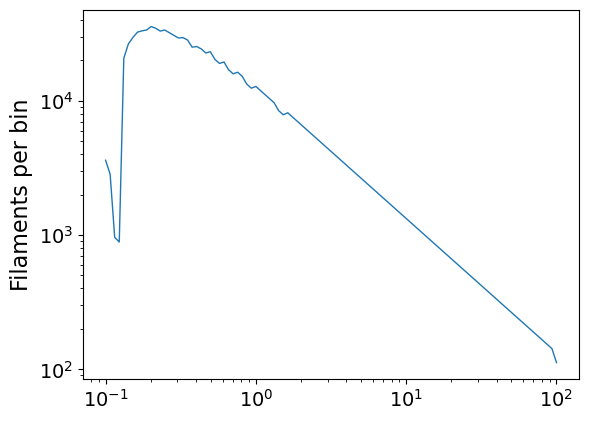

In [62]:
plt.plot(data2['rrs'][1][cutr:], data2['dnfil'][1][cutr:],lw=1,label='fwidth (cm)')
plt.ylabel('Filaments per bin')
plt.xscale('log')
plt.yscale('log')

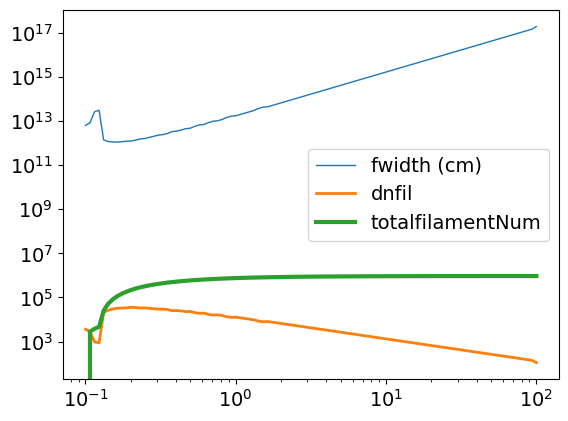

In [63]:
plt.plot(data2['rrs'][1][cutr:], data2['filament_width'][1][cutr:],lw=1,label='fwidth (cm)')
plt.plot(data2['rrs'][1][cutr:], data2['dnfil'][1][cutr:],lw=2,label='dnfil')
plt.plot(data2['rrs'][1][cutr:], data2['totalfilament'][1][cutr:],lw=3,label='totalfilamentNum')
plt.xscale('log')
plt.yscale('log')
plt.legend()

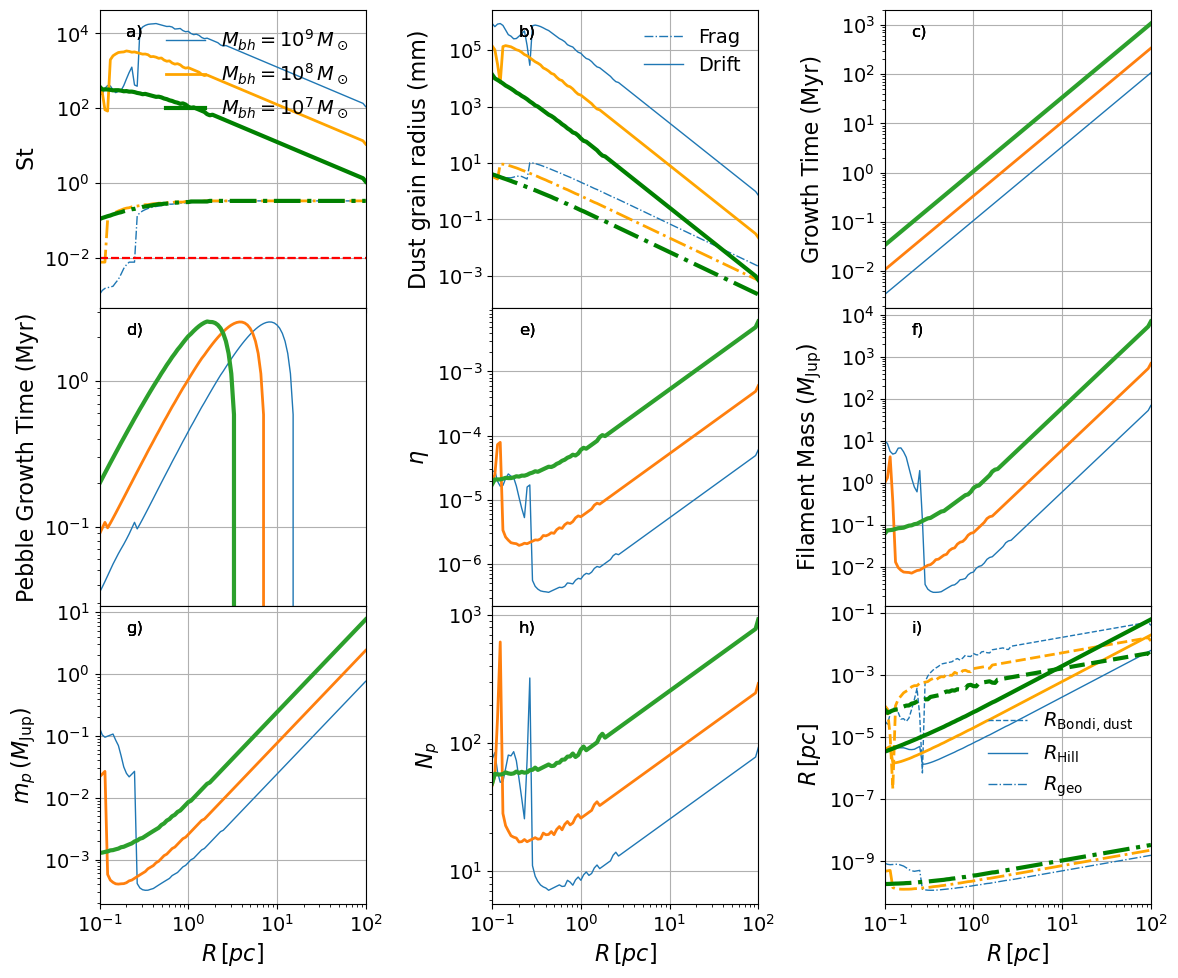

In [64]:
f, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, gridspec_kw=dict(hspace=0), tight_layout=True)
def plotstreaming(param,color,lw,variable,counter,cutr):
    #print(param['rrs'][1][cutr:][0])
    ax[0][0].plot(param['rrs'][1][cutr:], param['St_frag'][1][cutr:], color=color,lw=lw,linestyle='-.')
    ax[0][0].plot(param['rrs'][1][cutr:], param['St_drift'][1][cutr:],color=color,lw=lw,label=variable)
    # ax[0][0].text(x=10, y=100,s='Drift', ha='center', va='center', fontsize=font)
    # ax[0][0].text(x=10, y=2e-3,s='Frag', ha='center', va='center', fontsize=font)
    ax[0][0].axhline(y=SI_St_threshold, color='r', linestyle='--')
    
    ax[0][1].plot(param['rrs'][1][cutr:], param['a_frag'][1][cutr:],color=color,lw=lw,linestyle='-.',label='Frag')
    ax[0][1].plot(param['rrs'][1][cutr:], param['a_drift'][1][cutr:],color=color,lw=lw,label='Drift')
    ax[0][2].plot(param['rrs'][1][cutr:], param['tgrow'][1][cutr:],lw=lw)

    ax[1][0].plot(param['rrs'][1][cutr:], param['pebbletgrow'][1][cutr:],lw=lw)
    ax[1][1].plot(param['rrs'][1][cutr:], param['eta'][1][cutr:],lw=lw)    
    ax[1][2].plot(param['rrs'][1][cutr:], param['filamentmass'][1][cutr:],lw=lw)
    #ax[1][2].plot(param['rrs'][1][cutr:], param['roche_density'][1][cutr:],lw=lw)

    ax[2][0].plot(param['rrs'][1][cutr:], param['mmin/Mjup'][1][cutr:],lw=lw)
    
    ax[2][1].plot(param['rrs'][1][cutr:], param['Ntot (Filament Mass) '][1][cutr:],lw=lw)    
    ax[2][2].plot(param['rrs'][1][cutr:], param['RBondi_dust'][1][cutr:],color=color,lw=lw,linestyle='--',label=r'$R_{\rm Bondi,dust}$')
    ax[2][2].plot(param['rrs'][1][cutr:], param['RHill'][1][cutr:],color=color,lw=lw,label=r'$R_{\rm Hill}$')    
    ax[2][2].plot(param['rrs'][1][cutr:], param['Rgeo'][1][cutr:],color=color,lw=lw,linestyle='-.',label=r'$R_{\rm geo}$')
#    ax[2][2].plot(param['rrs'][1][cutr:], param['RBondi_gas'][1][cutr:],color=color,lw=lw,linestyle=':',label=r'$R_{\rm Bondi,gas}$')    

    # ax[0][1].legend(frameon=False,fontsize=font)
    ax[0][0].legend(frameon=False,fontsize=font)
    # ax[0][1].legend(frameon=False,fontsize=font)
    if (lw==1):
        ax[0][1].legend(frameon=False,fontsize=font)
    if(counter==0):ax[2][2].legend(frameon=False,fontsize=font)
    ax[0][0].set_ylabel(param['St_frag'][0])

    ax[0][1].set_ylabel(param['a_frag'][0])
    ax[0][2].set_ylabel(param['tgrow'][0])

    ax[1][0].set_ylabel(param['pebbletgrow'][0])

    ax[1][1].set_ylabel(param['eta'][0])    
    ax[1][2].set_ylabel(param['filamentmass'][0])
    #ax[1][2].set_ylabel(param['roche_density'][0])

    ax[2][0].set_ylabel(param['mmin/Mjup'][0])
    ax[2][1].set_ylabel(param['Ntot (Filament Mass) '][0])
    ax[2][2].set_ylabel(param['Rgeo'][0])

    ax[2][0].set_xlabel(r"$R \, [pc]$")
    ax[2][1].set_xlabel(r"$R \, [pc]$")
    ax[2][2].set_xlabel(r"$R \, [pc]$")

    ax[0][0].text(0.1, 0.95, "a)",transform=ax[0][0].transAxes, fontsize=12,va="top")
    ax[0][1].text(0.1, 0.95, "b)",transform=ax[0][1].transAxes, fontsize=12,va="top")
    ax[0][2].text(0.1, 0.95, "c)",transform=ax[0][2].transAxes, fontsize=12,va="top")
    ax[1][0].text(0.1, 0.95, "d)",transform=ax[1][0].transAxes, fontsize=12,va="top")
    ax[1][1].text(0.1, 0.95, "e)",transform=ax[1][1].transAxes, fontsize=12,va="top")
    ax[1][2].text(0.1, 0.95, "f)",transform=ax[1][2].transAxes, fontsize=12,va="top")
    ax[2][0].text(0.1, 0.95, "g)",transform=ax[2][0].transAxes, fontsize=12,va="top")
    ax[2][1].text(0.1, 0.95, "h)",transform=ax[2][1].transAxes, fontsize=12,va="top")
    ax[2][2].text(0.1, 0.95, "i)",transform=ax[2][2].transAxes, fontsize=12,va="top")
    
    plt.setp(ax,yscale='log',xscale='log')

    for i in range(3):
        for j in range(3):
            ax[i][j].grid()
            # ax[i][j].axvline(ragn /rs, -100, 100,color='r',ls='dashed')
            ax[i][j].set_xlim(1e-1,1e2)
    param = {}

plotstreaming(data1,'#1f77b4',1,plotvar[0],0,cutr)
plotstreaming(data2,'Orange',2,plotvar[1],1,cutr)
plotstreaming(data3,'Green',3,plotvar[2],2,cutr)
if(plotvar == variablealpha):
    plt.savefig("streamingInstability_alphavar_mbh1e6_zoom.png",format='png',transparent='True',bbox_inches='tight')
    plt.savefig("streamingInstability_alphavar_mbh1e6_zoom.pdf",format='pdf',transparent='True',bbox_inches='tight')    
if(plotvar == variablembh):
    plt.savefig("streamingInstability_alpha1em4_mbhvar_zoom.png",format='png',transparent='True',bbox_inches='tight')
    plt.savefig("streamingInstability_alpha1em4_mbhvar_zoom.pdf",format='pdf',transparent='True',bbox_inches='tight')
plt.show()


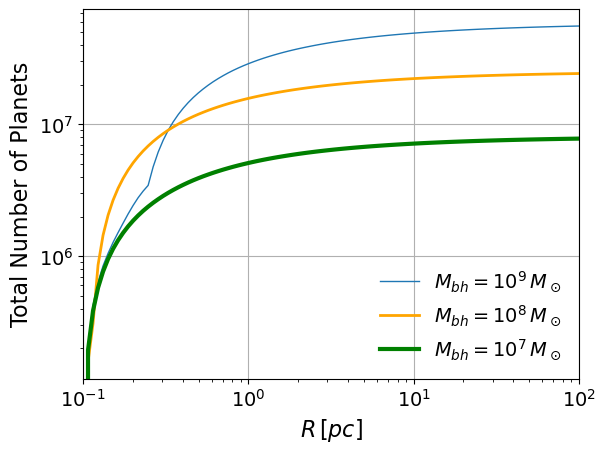

In [65]:
plt.plot(data1['rrs'][1][cutr:], data1['totalplanets'][1][cutr:],color='#1f77b4',lw=1,label=variablembh[0])
plt.plot(data1['rrs'][1][cutr:], data2['totalplanets'][1][cutr:],color='Orange',lw=2, label=variablembh[1])
plt.plot(data1['rrs'][1][cutr:], data3['totalplanets'][1][cutr:],color='Green',lw=3, label=variablembh[2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(frameon=False,fontsize=font)
plt.xlabel(r"$R \, [pc]$")
plt.xlim(1e-1, 1e2)
# plt.ylim(1e10,1e12)
plt.ylabel("Total Number of Planets")
plt.savefig("total_planets.png",format='png',transparent='True',bbox_inches='tight')

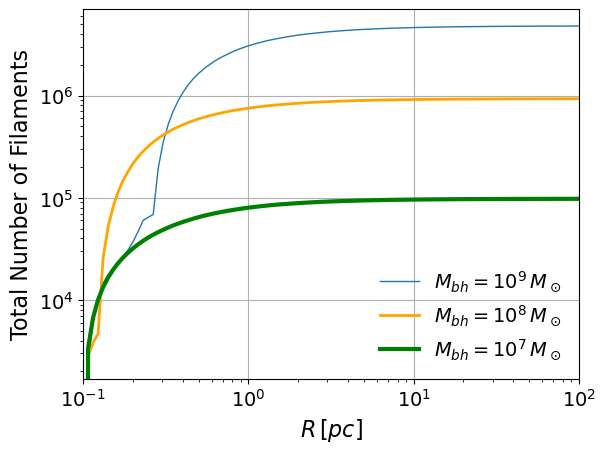

In [66]:
plt.plot(data1['rrs'][1][cutr:], data1['totalfilament'][1][cutr:],color='#1f77b4',lw=1,label=variablembh[0])
plt.plot(data1['rrs'][1][cutr:], data2['totalfilament'][1][cutr:],color='Orange',lw=2, label=variablembh[1])
plt.plot(data1['rrs'][1][cutr:], data3['totalfilament'][1][cutr:],color='Green',lw=3, label=variablembh[2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(frameon=False,fontsize=font)
plt.xlim(1e-1, 1e2)
# plt.ylim(1e3,1e5)
plt.xlabel(r"$R \, [pc]$")
plt.ylabel("Total Number of Filaments")
plt.savefig("total_filaments.png",format='png',transparent='True',bbox_inches='tight')


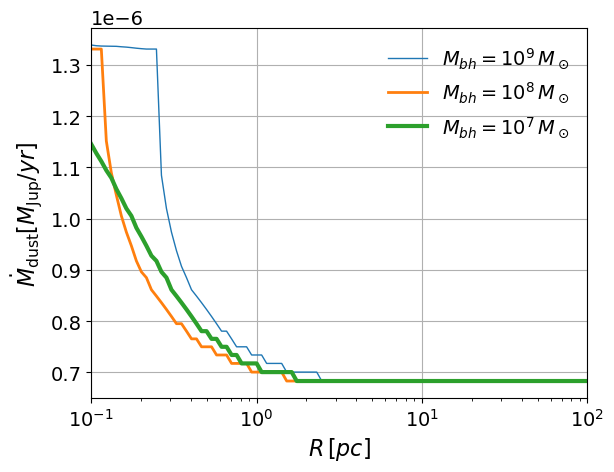

In [67]:
import scipy as sp

def Sfunction(r,Hd):
    y = (r/2/Hd)**2
    I0 = sp.special.iv(0, y) 
    I1 = sp.special.iv(1, y) 
    S = np.exp(-y) * (I0 + I1)
    return S

def calc_mdot(eta, r, omega, Rhat,Hp,mp,t_f,rho_dust,rhill,ldeltav,lOmegaR):
    dv_tp = 0.
    deltav   = eta*omega*r*rs
    if (ldeltav):
        dv_tp += deltav
    if (lOmegaR):
        dv_tp += omega*rhill
            
    tp  = G*mp /dv_tp**3
    fac = np.exp(-chi * (t_f/tp)**gamma)

    Racc = Rhat * fac
        
    dv=0.
    if (ldeltav):
        dv += deltav
    if (lOmegaR):
        dv += omega*Racc
     
    S = Sfunction(Racc,Hp)
    mdot = pi*  Racc**2 * rho_dust * dv * S
    
    return mdot

def getmdotdust(mmin, Sigma, r, H, St,omega, RH, Rpeb,eta):
    mp       = mmin*Mjup
    # SI_St_threshold = 1e-2
    # St       = SI_St_threshold
    Sa       = St*Sc/alpha
    chi      = 0.4
    Hp       = H *rs/ np.sqrt(Sa+1)
    
    deltav   = eta*omega*r*rs
    # print(deltav)
    M_C      = deltav**3 / G / omega  # C for Chris
    Mt       = M_C / 8 / St
    Mf       = M_C /  8 * St 
    
    rho_dust = Z*Sigma/np.sqrt(2*pi)/Hp
    mhb      = (eta*omega*r*rs)**3./(8.*St*G*omega) # eta^3*M/(8 St)
    rb       = G*mp/(eta*omega*r*rs)**2.
    tb       = rb/(eta*omega*r*rs)
    t_f      = St/omega
    Rgeo     = np.cbrt(3*mp/(4*pi*rho_bullet))
    Sgeo     = Sfunction(Rgeo,Hp)
    vesc          = np.sqrt(2*G*mp/Rgeo)
    Rhat_Bondi    = 2*np.sqrt(t_f/tb) *rb 
    Rhat_geo      = Rgeo*np.sqrt(1+vesc**2/deltav**2)
    Rhat_Hill     = np.cbrt(St/0.1) * RH*rs 
    R_Bondi       = G*mp / deltav**2
    Rhat          = np.zeros(n)
    for i in range(n):
        if (mp[i]>=Mt[i]):
            Rhat[i] = Rhat_Hill[i]
        else:
            Rhat[i] = Rhat_Bondi[i]
            
    mdot_pebble    = calc_mdot(eta, r, omega, Rhat      ,Hp,mp,t_f,rho_dust,RH,True ,True) #lDeltav, lOmegaR              

    mdot_Hill      = calc_mdot(eta, r, omega,Rhat_Hill ,Hp,mp,t_f,rho_dust,RH,False,True) #lDeltav, lOmegaR               
    mdot_Bondi     = calc_mdot(eta, r, omega,Rhat_Bondi,Hp,mp,t_f,rho_dust,RH,True ,True) #lDeltav, lOmegaR  
    
    mdot_focusing = np.zeros(n)
    for i in range(n):
        Stk = deltav[i] * t_f[i] / Rgeo[i]
        if (Stk > 1): 
            mdot_focusing[i] = np.pi*Rhat_geo[i]**2 * rho_dust[i] * deltav[i] * Sgeo[i] 
        else:
            mdot_focusing[i] = 0. 
    # print(mdot_focusing)
    #polydisperse Bondi
    a   = Rpeb
    s   = 0.65
    tp  = G*mp /(deltav+omega*RH*rs)**3
    Stp = (np.pi/2)/Sigma *rho_bullet
    jp  = chi*(Stp/omega/tp)**s
    j1  = 2*jp
    j2  = j1
    j3  = 3*jp
    j4  = j3
    mprime = 4*pi/3 * rho_bullet
    b1 = 0.5
    b2 = 1.
    b3 = b2
    b4 = 1.5
    
    p = r/Sigma * np.gradient(Sigma)/np.gradient(r)
    D       = 3*(1-p)*Z*Sigma*R_Bondi*deltav**2/(np.sqrt(2*pi)*H*rs*omega*rho_bullet*np.sqrt(a)) 
    C1      = D*Stp*mprime
    C2      = D*Stp**(3/2)*mprime/np.sqrt(alpha/Sc)
    C3      = 2*D*Stp**(3/2)*mprime*np.sqrt(omega*R_Bondi/deltav)
    C4      = 2*D*Stp**(2)*mprime*np.sqrt(omega*R_Bondi/deltav/(alpha/Sc))
    
    gammal1 = sp.special.gammainc((b1+1)/s,j1*a**s)*sp.special.gamma((b1+1)/s)
    gammal2 = sp.special.gammainc((b2+1)/s,j2*a**s)*sp.special.gamma((b2+1)/s)
    gammal3 = sp.special.gammainc((b3+1)/s,j3*a**s)*sp.special.gamma((b3+1)/s)
    gammal4 = sp.special.gammainc((b4+1)/s,j4*a**s)*sp.special.gamma((b4+1)/s)
    
    G1 = C1*gammal1/s/j1**((b1+1)/s)
    G2 = C2*gammal2/s/j2**((b2+1)/s)
    G3 = C3*gammal3/s/j3**((b3+1)/s)
    G4 = C4*gammal4/s/j4**((b4+1)/s)
    # print(G1)
    mdot_Bondi = G1 + G2 + G3 + G4
    # print(mdot_Bondi)
    mdot=np.zeros(n)
    for i in range(n):
        mdot[i]=max(mdot_Bondi[i],mdot_focusing[i])
    
    return mdot_Hill #mdot

mdotdust1 = getmdotdust(data1['mmin/Mjup'][1], param_dic1['Sigmag'][1], param_dic1['rrs'][1], 
                        param_dic1['h'][1]*param_dic1['rrs'][1], data1['St_frag'][1], param_dic1['Omega'][1], data1['RHill'][1], data1['Rpeb'][1],data1['eta'][1] )

mdotdust2 = getmdotdust(data2['mmin/Mjup'][1],param_dic2['Sigmag'][1], param_dic2['rrs'][1], 
                        param_dic2['h'][1]*param_dic2['rrs'][1], data2['St_frag'][1], param_dic2['Omega'][1], data2['RHill'][1], data2['Rpeb'][1], data2['eta'][1])

mdotdust3 = getmdotdust(data3['mmin/Mjup'][1],param_dic3['Sigmag'][1], param_dic3['rrs'][1], 
                        param_dic3['h'][1]*param_dic3['rrs'][1], data3['St_frag'][1], param_dic3['Omega'][1], data3['RHill'][1],data3['Rpeb'][1], data3['eta'][1])


timeplanet1 = data1['mmin/Mjup'][1]*Mjup/mdotdust1
timeplanet2 = data2['mmin/Mjup'][1]*Mjup/mdotdust2
timeplanet3 = data3['mmin/Mjup'][1]*Mjup/mdotdust3

plt.plot(param_dic1['rrs'][1],mdotdust1/Mjup*yr, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],mdotdust2/Mjup*yr, lw=2, label=plotvar[1])
plt.plot(param_dic3['rrs'][1],mdotdust3/Mjup*yr, lw=3, label=plotvar[2])


plt.ylabel('$\dot{M}_\mathrm{dust} [M_\mathrm{Jup}/yr]$')
# plt.ylabel('Mhb/Mearth')
plt.xscale('log')
#plt.yscale('log')
# plt.xlim(0.027825594022071264,100)
# plt.ylim(1e-12,1e1)
plt.xlim(1e-1, 1e2)
plt.xlabel(r"$R \, [pc]$")
plt.grid()
plt.legend(frameon=False,fontsize=font)
if(plotvar == variablealpha):
    plt.savefig("mdotdust_alphavar_mbh1e6.png",format='png',transparent='True',bbox_inches='tight')

if(plotvar == variablembh):
    plt.savefig("mdotdust_alpha1em4_mbhvar.png",format='png',transparent='True',bbox_inches='tight')
plt.show()

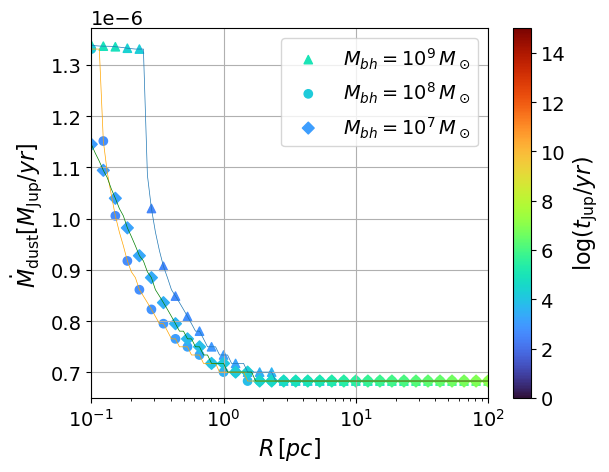

In [68]:
# from matplotlib import colormaps
import matplotlib as mpl
import matplotlib.cm
plt.scatter(param_dic1['rrs'][1][::3],mdotdust1[::3]/Mjup*yr, c=np.log10(timeplanet1[::3]/yr), marker='^',label=plotvar[0] , cmap='turbo')
plt.plot(param_dic1['rrs'][1],mdotdust1/Mjup*yr, lw=0.5, color='#1f77b4')
plt.clim(0,15)
plt.scatter(param_dic2['rrs'][1][::3],mdotdust2[::3]/Mjup*yr, c=np.log10(timeplanet2[::3]/yr), marker='o',label=plotvar[1] , cmap='turbo')
plt.plot(param_dic2['rrs'][1],mdotdust2/Mjup*yr, lw=0.5, color='orange')
plt.clim(0,15)
plt.scatter(param_dic3['rrs'][1][::3],mdotdust3[::3]/Mjup*yr, c=np.log10(timeplanet3[::3]/yr), marker='D',label=plotvar[2] , cmap='turbo')
plt.plot(param_dic3['rrs'][1],mdotdust3/Mjup*yr, lw=0.5, color='green')
plt.clim(0,15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=font)
cbar.set_label('$\log (t_\mathrm{Jup}/yr)$')
plt.ylabel('$\dot{M}_\mathrm{dust} [M_\mathrm{Jup}/yr]$ ')
plt.xlabel(r"$R \, [pc]$")
plt.xscale('log')
#plt.yscale('log')
plt.legend(frameon=True,fontsize=font)
# plt.ylim(1e-8,1)
plt.xlim(1e-1, 1e2)
plt.xlabel(r"$R \, [pc]$")
plt.grid()
plt.savefig("timeMjupMdotdust_alpha1em4_mbhvar.png",format='png',transparent='True',bbox_inches='tight')
plt.savefig("timeMjupMdotdust_alpha1em4_mbhvar.pdf",format='pdf',transparent='True',bbox_inches='tight')


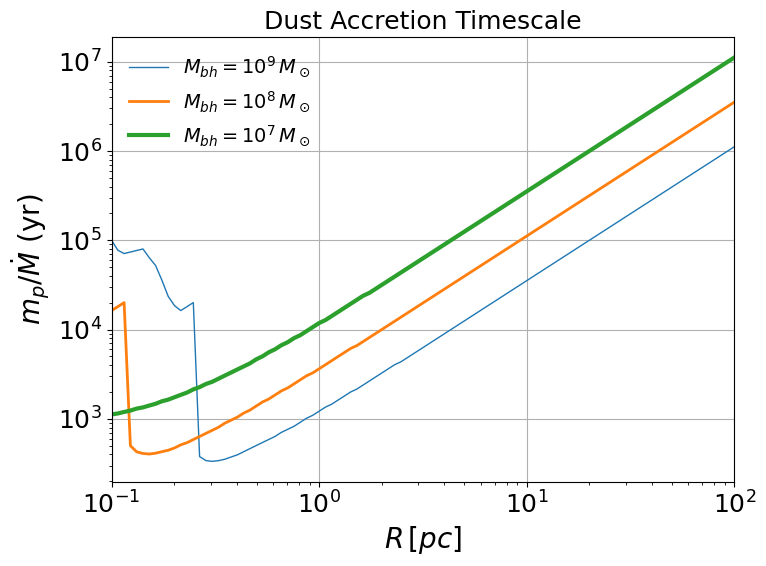

In [69]:
xsize=8
ysize=8/1.61

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(8, 6))

plt.plot(param_dic1['rrs'][1],timeplanet1/yr, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],timeplanet2/yr, lw=2, label=plotvar[1])
plt.plot(param_dic3['rrs'][1],timeplanet3/yr, lw=3, label=plotvar[2])
plt.xlim(0.027825594022071264,1e2)
# plt.ylim(1e4,1e9)
plt.xlim(1e-1, 1e2)
plt.tick_params(axis='both', which='minor', labelsize=16)
# plt.hline()
plt.xscale('log')
plt.yscale('log')
plt.title("Dust Accretion Timescale")
plt.ylabel(r'$m_p/\dot{M}$ (yr)')
plt.xlabel(r"$R \, [pc]$")
plt.legend(frameon=False,fontsize=font)
plt.grid()
plt.tight_layout()
plt.savefig("timeMjupDust_delta1em5_mbhvar.png",format='png',transparent='True',bbox_inches='tight')
plt.savefig("timeMjupDust_delta1em5_mbhvar.pdf",format='pdf',transparent='True',bbox_inches='tight')

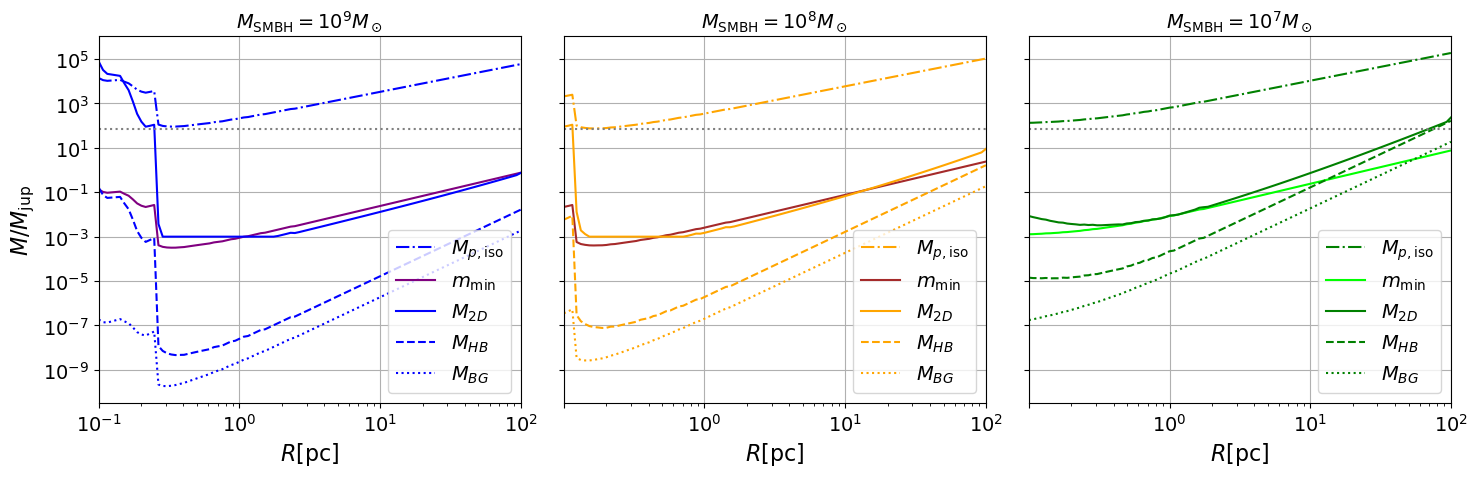

In [70]:
import numpy as np
from scipy.optimize import root_scalar

def get_phi_mass(mass,data,par,i):
    r = par['rrs'][1][i]*rs    
    omega=par['Omega'][1][i]    
    H = par['h'][1][i] * r
    St = data['St_frag'][1][i]    
    eta=data['eta'][1][i]
     
    Mbh=omega**2*r**3/G 
    Rhill = r*cbrt(mass/Mbh/3)
    Racchat = cbrt(St/0.1) * Rhill
    tau=St/omega
    deltav = eta*omega*r
    tp  = G*mass /(deltav+omega*Rhill)**3
    Racc=Racchat * exp(-0.4*(tau/tp)**0.65)
    Hd = H * sqrt(alpha/(St*Sc+alpha))    
    phi  =  Racc-2*Hd   
    return phi

def bisection_mass(left,right,data,par,i):
    maxit  = 10000
    icount = 0
    mass_precision=1e-10*Mjup
    while abs(right - left) > 2 * mass_precision:
        midpoint = 0.5 * (right + left)
        phileft  = get_phi_mass(left,data,par,i)
        phimid   = get_phi_mass(midpoint,data,par,i)
        if phileft * phimid < 0:
            right = midpoint
        else:
            left = midpoint

        icount += 1
        if icount > maxit:
            print("left, right =", left, right)
            raise RuntimeError("bisection_mass: exceeds maximum number of iterations")

    mass = 0.5 * (right + left)

    return mass

St_form=SI_St_threshold 
St1_acc=data1['St_frag'][1]
St2_acc=data2['St_frag'][1]
St3_acc=data3['St_frag'][1]

mt9=param_dic1['h'][1][cutr:]**6*1e9*Msun; mhb9 = mt9/(8*St1_acc); mbg9 = mt9/8*St1_acc
mt8=param_dic2['h'][1][cutr:]**6*1e8*Msun; mhb8 = mt8/(8*St2_acc); mbg8 = mt8/8*St2_acc
mt7=param_dic3['h'][1][cutr:]**6*1e7*Msun; mhb7 = mt7/(8*St3_acc); mbg7 = mt7/8*St3_acc

nrows=1
ncols=3
xsize=15
ysize=5

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

m2d_1=np.zeros(n)
m2d_2=np.zeros(n)
m2d_3=np.zeros(n)
for i in range(n):
    m2d_1[i]  = bisection_mass(1e5*Mjup,1e-3*Mjup,data1,param_dic1,i)
    m2d_2[i]  = bisection_mass(1e5*Mjup,1e-3*Mjup,data2,param_dic2,i)    
    m2d_3[i]  = bisection_mass(1e5*Mjup,1e-3*Mjup,data3,param_dic3,i)    

fig, ax = plt.subplots(ncols=ncols,figsize=(xsize,ysize),sharey=True)

xticks = np.logspace(-1, 2, 4) 

#check pebble isolation mass; 85% of Sigma_gap

gap_ratio = 0.85
K = 1./0.04 * (1/gap_ratio - 1)

mp1_iso = np.sqrt(K * alpha) * param_dic1['h'][1] **2.5 * 1e9*Msun
mp2_iso = np.sqrt(K * alpha) * param_dic2['h'][1] **2.5 * 1e8*Msun
mp3_iso = np.sqrt(K * alpha) * param_dic3['h'][1] **2.5 * 1e7*Msun

yscale('log')
xscale('log')


ax[0].plot(param_dic1['rrs'][1][cutr:], mp1_iso[cutr:]/Mjup,color='blue',linestyle="dashdot",label=r'$M_{p,\rm iso}$')
ax[0].plot(param_dic1['rrs'][1][cutr:], data1['mmin/Mjup'][1][cutr:],color='purple',label=r'$m_{\rm min}$')
ax[0].plot(param_dic1['rrs'][1][cutr:], m2d_1/Mjup,color='blue',linestyle="solid",label=r'$M_{2D}$')
ax[0].plot(param_dic1['rrs'][1][cutr:], mhb9/Mjup,color='blue',linestyle="dashed",label=r'$M_{HB}$')
#ax[0].plot(param_dic1['rrs'][1][cutr:], mt9/Mjup,color='blue',label=r'$M_t$')
ax[0].plot(param_dic1['rrs'][1][cutr:], mbg9/Mjup,color='blue',linestyle="dotted",label=r'$M_{BG}$')

ax[1].plot(param_dic2['rrs'][1][cutr:], mp2_iso[cutr:]/Mjup,color='orange',linestyle="dashdot",label=r'$M_{p,\rm iso}$')
ax[1].plot(param_dic2['rrs'][1][cutr:], data2['mmin/Mjup'][1][cutr:],color='brown',label=r'$m_{\rm min}$')
ax[1].plot(param_dic2['rrs'][1][cutr:], m2d_2/Mjup,color='orange',linestyle="solid",label=r'$M_{2D}$')
ax[1].plot(param_dic2['rrs'][1][cutr:], mhb8/Mjup,color='orange',linestyle="dashed",label=r'$M_{HB}$')
#ax[1].plot(param_dic2['rrs'][1][cutr:], mt8/Mjup,color='orange',label=r'$M_t$')
ax[1].plot(param_dic2['rrs'][1][cutr:], mbg8/Mjup,color='orange',linestyle="dotted",label=r'$M_{BG}$')

ax[2].plot(param_dic3['rrs'][1][cutr:], mp3_iso[cutr:]/Mjup,color='green',linestyle="dashdot",label=r'$M_{p,\rm iso}$')
ax[2].plot(param_dic3['rrs'][1][cutr:], data3['mmin/Mjup'][1][cutr:],color='lime',label=r'$m_{\rm min}$')
ax[2].plot(param_dic3['rrs'][1][cutr:], m2d_3/Mjup,color='green',linestyle="solid",label=r'$M_{2D}$')
ax[2].plot(param_dic3['rrs'][1][cutr:], mhb7/Mjup,color='green',linestyle="dashed",label=r'$M_{HB}$')
#ax[2].plot(param_dic3['rrs'][1][cutr:], mt7/Mjup,color='green',label=r'$M_t$')
ax[2].plot(param_dic3['rrs'][1][cutr:], mbg7/Mjup,color='green',linestyle="dotted",label=r'$M_{BG}$')

for axi in ax: 
    axi.grid()
    axi.legend(loc='lower right')
    axi.set_xlim(1e-1,1e2)
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.set_xlabel(r'$R$[pc]')
    axi.set_xticks(xticks)
#    axi.axhline(13,linestyle='dotted',color='grey')
    axi.axhline(0.07*Msun/Mjup,linestyle='dotted',color='grey')

ax[0].set_title(r'$M_{\rm SMBH}=10^9 M_\odot$')
ax[1].set_title(r'$M_{\rm SMBH}=10^8 M_\odot$')
ax[2].set_title(r'$M_{\rm SMBH}=10^7 M_\odot$')

ax[0].set_ylabel(r'$M/M_\mathrm{jup}$')

fig.subplots_adjust(wspace=0)

for axi in ax[1:]:
    labels = axi.get_xticklabels()
    if labels:
        labels[0].set_visible(False)

plt.tight_layout()
plt.savefig("pebble_accretion_regimes.pdf", bbox_inches='tight')
plt.savefig("pebble_accretion_regimes.png", bbox_inches='tight')

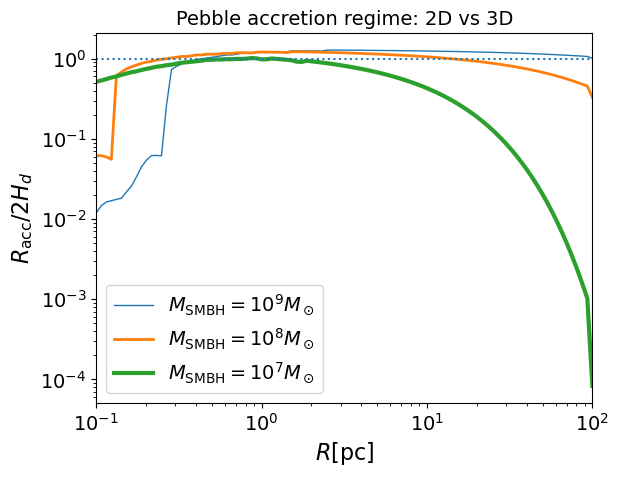

In [71]:
# Ok the radius is at Hill; where's the 2D/3D transition?

gamma=0.65
chi=0.4

def r2h(par,data):
    r = par['rrs'][1]*rs
    H = par['h'][1] * r
    St = data['St_frag'][1]
    Rhill=data['RHill'][1] * rs 
    omega=par['Omega'][1]
    eta=data['eta'][1]
    Racchat = cbrt(St/0.1) * Rhill
    Hd = H * sqrt(alpha/(St*Sc+alpha))
    tau=St/omega
    deltav = eta*omega*r
    tp  = G*data['mmin/Mjup'][1][cutr:]*Mjup /(deltav+omega*Rhill)**3
    Racc = Racchat * exp(-0.4*(tau/tp)**0.65)
    return .5*Racc/Hd

plot(param_dic1['rrs'][1],r2h(param_dic1,data1)[cutr:],label=r'$M_{\rm SMBH}=10^9 M_\odot$',lw=1)
plot(param_dic2['rrs'][1],r2h(param_dic2,data2)[cutr:],label=r'$M_{\rm SMBH}=10^8 M_\odot$',lw=2)
plot(param_dic3['rrs'][1],r2h(param_dic3,data3)[cutr:],label=r'$M_{\rm SMBH}=10^7 M_\odot$',lw=3)

axhline(1,linestyle='dotted')

legend()

xscale('log')
yscale('log')
ylabel(r'$R_{\rm acc}/2H_d$')

title("Pebble accretion regime: 2D vs 3D")

xlabel(r'$R$[pc]')

xlim(1e-1,1e2)
#grid()


plt.savefig("pebble_accretion_2dv3d.pdf")
plt.savefig("pebble_accretion_2dv3d.png")

For gas accretion, follow Pollack. Stellar structure equation; if a mass dm is added, the radius increased by dr 

\begin{equation}
dm = 4\pi r^2 \rho dr
\end{equation}

divide by dt 

\begin{equation}
\frac{dm}{dt} = 4\pi r^2 \rho \frac{dr}{dt}
\end{equation}

if $r=R_b=GM/cs^2$, the Bondi radius, then $dr/dt = G/c_s^2 \dot{M}$
so

\begin{eqnarray}
\dot{M}_{xy} &=& 4\pi R_b^2 \rho G/c_s^2  \dot{M}_{z}\\
&=& 4\pi G^3 m_p^2 \rho /c_s^6  \dot{M}_z
\end{eqnarray}

i.e., the pebble accretion rate and gas accretion rate scale by a factor $4πG^3 m_p^2 \rho /c_s^6$. 

This should be valid as long as $Rb < Rh$, and the temperature at the bondi radius is the same as in the nebula. This formula matches the 6 order of mag difference between solid and gas accretion rate in Pollack et al. 1996. 

In the following code, I'll write this as 

\begin{eqnarray}
\frac{\dot{M}_{xy}}{\dot{M}_z} &=& f_1 m_p^2\\
&=& f_2 q^2
\end{eqnarray}

where $q=m_p/M$ is the mass ratio, so $f_2=f_1M^2$. 


\begin{eqnarray}
f_1&=&4πG^3 \rho /c_s^6\\
f_2&=&4\pi G \rho / (\Omega^2 h^6 \beta_m^3)
\end{eqnarray}


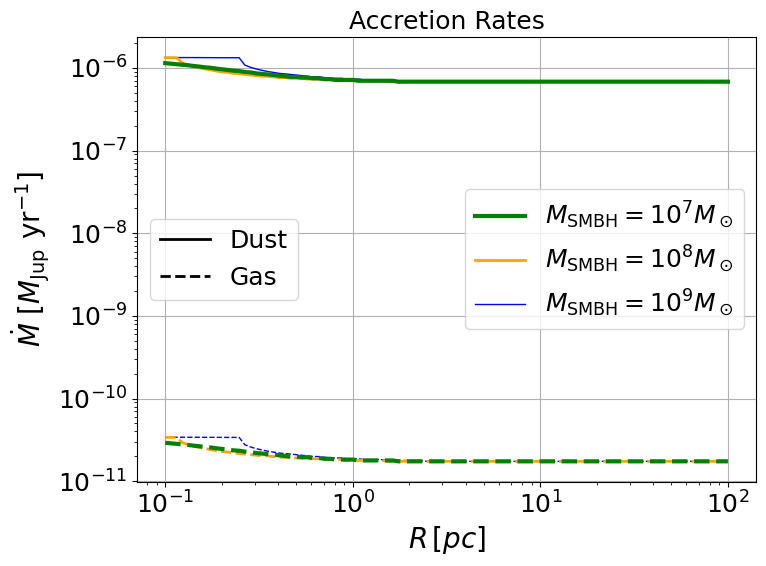

In [72]:

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


xsize=8
ysize=8/1.61

plt.figure(figsize=(8, 6))


from matplotlib.lines import Line2D


mp = data1['mmin/Mjup'][1]*Mjup
rho = param_dic1['rho'][1]
cs = param_dic1['cs'][1]
h = param_dic1['h'][1]
Omega = param_dic1['Omega'][1]
# fac1 = ratio between gas and dust accretion 
fac1 =  4*pi*rho*G**3 / cs**6
# ffac1 is the ratio mdot_xy/mdot_z in terms of mass ratio
ffac1 =  4*pi*rho*G/(h**6*Omega**2) / betam**3
mdotxy1 = fac1 * mp**2 * mdotdust1 


plot(param_dic1['rrs'][1],mdotxy1/Mjup*yr,color='blue',linestyle='dashed',lw=1)
plot(param_dic1['rrs'][1],mdotdust1/Mjup*yr,color='blue',linestyle='solid',lw=1,label=r'$M_{\rm SMBH}=10^9 M_\odot$')


mp = data2['mmin/Mjup'][1]*Mjup
rho = param_dic2['rho'][1]
cs = param_dic2['cs'][1]
h = param_dic2['h'][1]
Omega = param_dic2['Omega'][1]
fac2 =  4*pi*rho*G**3  / cs**6
ffac2 =  4*pi*rho*G/(h**6*Omega**2) / betam**3
mdotxy2 = fac2 * mp**2 * mdotdust2
plot(param_dic2['rrs'][1],mdotxy2/Mjup*yr,color='orange',linestyle='dashed',lw=2)
plot(param_dic2['rrs'][1],mdotdust2/Mjup*yr,color='orange',linestyle='solid',lw=2,label=r'$M_{\rm SMBH}=10^8 M_\odot$')


mp = data3['mmin/Mjup'][1]*Mjup
rho = param_dic3['rho'][1]
cs = param_dic3['cs'][1]
h = param_dic3['h'][1]
Omega = param_dic3['Omega'][1]
fac3 =  4*pi*rho*G**3 / cs**6
ffac3 =  4*pi*rho*G/(h**6*Omega**2) / betam**3
mdotxy3 = fac3 * mp**2 * mdotdust3
plot(param_dic3['rrs'][1],mdotxy3/Mjup*yr,color='green',linestyle='dashed',lw=3)
plot(param_dic3['rrs'][1],mdotdust3/Mjup*yr,color='green',linestyle='solid',lw=3,label=r'$M_{\rm SMBH}=10^7 M_\odot$')

xscale('log')
yscale('log')
grid()

# Create both custom legends
color_legend = [
    Line2D([0], [0], color='green', lw=3, label=r'$M_{\rm SMBH}=10^7 M_\odot$'),
    Line2D([0], [0], color='orange', lw=2, label=r'$M_{\rm SMBH}=10^8 M_\odot$'),
    Line2D([0], [0], color='blue', lw=1, label=r'$M_{\rm SMBH}=10^9 M_\odot$')
]
style_legend = [
    Line2D([0], [0], color='black', linestyle='solid', lw=2, label='Dust'),
    Line2D([0], [0], color='black', linestyle='dashed', lw=2, label='Gas')
]

# First legend: color
leg1 = legend(handles=color_legend, loc='center right')

# Manually add the first legend to current axes so it doesn't get replaced
plt.gca().add_artist(leg1)

# Second legend: linestyle
legend(handles=style_legend, loc='center left')


plt.ylabel('$\dot{M} \ [M_\mathrm{Jup} \ \mathrm{yr}^{-1}]$')
plt.xlabel(r"$R \, [pc]$")

#show()

plt.title("Accretion Rates")

plt.tight_layout()
plt.savefig("accretion_dustgas.pdf", bbox_inches='tight')
plt.savefig("accretion_dustgas.png", bbox_inches='tight')


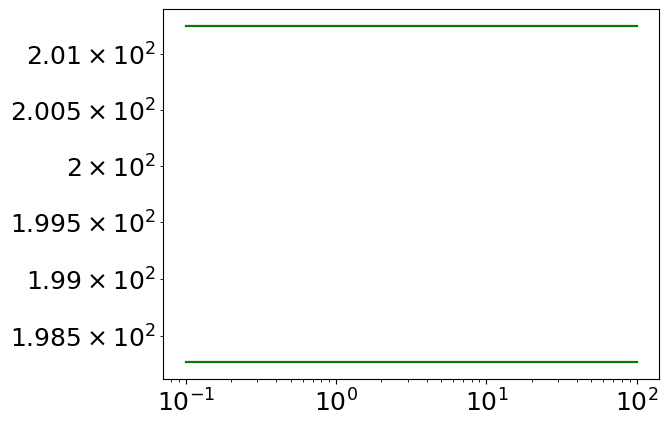

In [73]:
mp1=data1['mmin/Mjup'][1]*Mjup
mp2=data2['mmin/Mjup'][1]*Mjup
mp3=data3['mmin/Mjup'][1]*Mjup

r1=param_dic1['rrs'][1]
r2=param_dic2['rrs'][1]
r3=param_dic3['rrs'][1]

qmin1=mp1 / (1e9*Msun)
qmin2=mp2 / (1e8*Msun)
qmin3=mp3 / (1e7*Msun)

plot(r1,1/(sqrt(ffac1) * qmin1) ,color='blue')
plot(r2,1/(sqrt(ffac2) * qmin2) ,color='orange')
plot(r3,1/(sqrt(ffac3) * qmin3) ,color='green')


plot(r1,1/(sqrt(fac1) * mp1) ,color='blue')
plot(r2,1/(sqrt(fac2) * mp2) ,color='orange')
plot(r3,1/(sqrt(fac3) * mp3) ,color='green')

yscale('log')
xscale('log')


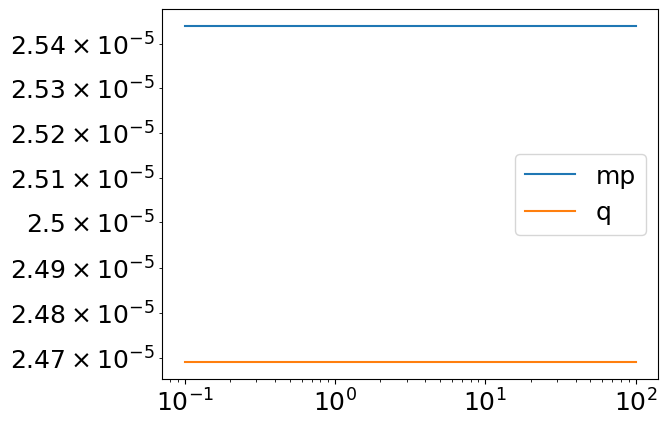

In [74]:


mdotxy1 = fac1 * mp1**2
mdotxy2 = ffac1 * qmin1**2

plot(r1,mdotxy1,label='mp')
plot(r1,mdotxy2,label='q')

yscale('log')
xscale('log')

legend()


(0.0278, 100.0)

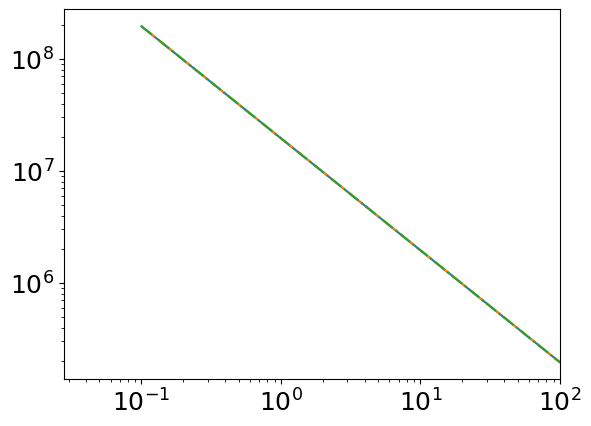

In [75]:
plt.plot(param_dic1['rrs'][1], param_dic1['h'][1]*param_dic1['rs'][1]/(data1['RHill'][1]*AU),ls='-')
plt.plot(param_dic2['rrs'][1], param_dic2['h'][1]*param_dic2['rs'][1]/(data2['RHill'][1]*AU), ls='--')
plt.plot(param_dic3['rrs'][1], param_dic3['h'][1]*param_dic3['rs'][1]/(data3['RHill'][1]*AU),ls='-.')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0278,1e2)


In [76]:
plt.plot(param_dic1['rrs'][1],data1['mdotbondi'][1]/Mjup*yr, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],data2['mdotbondi'][1]/Mjup*yr, lw=2, label=plotvar[1])
plt.plot(param_dic3['rrs'][1],data3['mdotbondi'][1]/Mjup*yr, lw=3, label=plotvar[2])
plt.ylabel('$\dot{M}_\mathrm{Bondi}$ [M_jup/yr]')
plt.legend(frameon=False,fontsize=font)
plt.xlabel(r"$R \, [pc]$")
plt.xlim(1e-1, 1e2)
plt.ylim(1e-12,1)
# plt.hline()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig("mdotBondi_alpha1em4_mbhvar.png",format='png',transparent='True',bbox_inches='tight')

KeyError: 'mdotbondi'

In [ ]:
timegas1 = data1['mmin/Mjup'][1]*Mjup/data1['mdotbondi'][1]
timegas2 = data2['mmin/Mjup'][1]*Mjup/data2['mdotbondi'][1]
timegas3 = data3['mmin/Mjup'][1]*Mjup/data3['mdotbondi'][1]
plt.plot(param_dic1['rrs'][1],timegas1/yr, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],timegas2/yr, lw=2, label=plotvar[1])
plt.plot(param_dic3['rrs'][1],timegas3/yr, lw=3, label=plotvar[2])
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.ylabel('Tearth/yr [Bondi Gas Accretion]')
plt.legend(frameon=False,fontsize=font)
plt.xlabel(r"$R \, [pc]$")
plt.xlim(1e-1, 1e2)
plt.ylim(0.08,1e13)
# plt.hline()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig("timeMjupBondiGas_alpha1em4_mbhvar.png",format='png',transparent='True',bbox_inches='tight')

In [ ]:
climmin=1;climmax=5
plt.scatter(param_dic1['rrs'][1][::3],data1['mdotbondi'][1][::3]/Mjup*yr, c=np.log10(timegas1[::3]/yr),marker='^', label=plotvar[0] , cmap='turbo')
plt.plot(param_dic1['rrs'][1],data1['mdotbondi'][1]/Mjup*yr, lw=0.5, color='#1f77b4')
plt.clim(climmin, climmax)
plt.scatter(param_dic2['rrs'][1][::3],data2['mdotbondi'][1][::3]/Mjup*yr, c=np.log10(timegas2[::3]/yr), marker='o' , label=plotvar[1], cmap='turbo')
plt.plot(param_dic2['rrs'][1],data2['mdotbondi'][1]/Mjup*yr, lw=0.5, color='#1f77b4')
plt.clim(climmin, climmax)
plt.scatter(param_dic3['rrs'][1][::3],data3['mdotbondi'][1][::3]/Mjup*yr, c=np.log10(timegas3[::3]/yr), marker='D' , label=plotvar[2], cmap='turbo')
plt.plot(param_dic3['rrs'][1],data3['mdotbondi'][1]/Mjup*yr, lw=0.5, color='#1f77b4')
plt.clim(climmin, climmax)
plt.tick_params(axis='both', which='minor', labelsize=font)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=font)
cbar.set_label('$\log (t_\mathrm{Jup}/yr)$')
plt.ylabel('$\dot{M}_\mathrm{Bondi} [M_\mathrm{Jup}/yr] $') #call it gas accretion
plt.xlabel(r"$R \, [pc]$")
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True,fontsize=font)
# plt.ylim(1e-11,5e-7)
plt.xlim(1e-1, 1e2)
plt.xlabel(r"$R \, [pc]$")
plt.grid()
plt.savefig("timeMjupMdotBondi_alpha1em4_mbhvar.png",format='png',transparent='True',bbox_inches='tight')

In [ ]:
from scipy.integrate import simps, trapz
totalplanetmassBondi1 = data1['mdotbondi'][1]/Mearth*yr*1e8
totalplanetmassBondi2 = data2['mdotbondi'][1]/Mearth*yr*1e8
totalplanetmassBondi3 = data3['mdotbondi'][1]/Mearth*yr*1e8

plt.plot(param_dic1['rrs'][1],totalplanetmassBondi1, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],totalplanetmassBondi2, lw=2, label=plotvar[0])
plt.plot(param_dic3['rrs'][1],totalplanetmassBondi3, lw=3, label=plotvar[0])

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2, 1e2)
plt.ylim(1e-2,5e8)
plt.xlabel(r"$R \, [pc]$")
plt.ylabel('M_total_Bondi')
plt.grid()
plt.savefig("totalMassOverAGNDiskLifeBondi.png",format='png',transparent='True',bbox_inches='tight')

In [ ]:
totalplanetmassDust1 = mdotdust1/Mearth*yr*1e8
totalplanetmassDust2 = mdotdust2/Mearth*yr*1e8
totalplanetmassDust3 = mdotdust3/Mearth*yr*1e8

plt.plot(param_dic1['rrs'][1],totalplanetmassDust1, lw=1, label=plotvar[0])
plt.plot(param_dic2['rrs'][1],totalplanetmassDust2, lw=2, label=plotvar[0])
plt.plot(param_dic3['rrs'][1],totalplanetmassDust3, lw=3, label=plotvar[0])

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2, 1e2)
plt.ylim(1e4,1e9)
plt.xlabel(r"$R \, [pc]$")
plt.ylabel('M_total_Dust')
plt.grid()
plt.savefig("totalMassOverAGNDiskLifeDust.png",format='png',transparent='True',bbox_inches='tight')

In [ ]:
timecool = np.linspace(0,10**6*yr,100)
mfinal = []
mplus = 0.
E = []
L = []
for i in range(len(mdotdust2)):
    mplus += (Mearth + mdotdust2[50]*timecool[i])
    E.append(G*mplus**2./np.cbrt(3.*mplus/(4.*np.pi*3.5)))
    L.append(0.06*mdotdust2[i]*c**2.)
    mfinal.append(mplus)
    
timeKH = np.array(E)/np.array(L)
plt.plot(np.array(mfinal)/Mearth,timeKH/yr)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10,1e5)
# plt.grid()

# timecool = np.linspace(0,10**6*yr,100)
# mfinal = []
# mplus = 0.
# E = []
# L = []
# for i in range(len(data2['mdotbondi'][1])):
#     mplus += (Mearth + data2['mdotbondi'][1][i]*timecool[i])
#     E.append(G*mplus**2./Rearth)
#     L.append(0.06*data2['mdotbondi'][1][i]*c**2.)
#     mfinal.append(mplus)
    
# timeKH = np.array(E)/np.array(L)
# plt.plot(np.array(mfinal)/Mearth,timeKH/yr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("M/Mearth")
plt.ylabel("tcool (dust)/yr")
plt.xlim(10,1e8)
# plt.ylim(1e-8,1e8)
plt.grid()


